In [ ]:
#check that we have GPU acceleration enabled

!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f1a6a2ae-7da6-732c-b007-55fc95a88e48)


In [ ]:
#install the necessary packages

%%capture install_log
!apt-get install libsox-fmt-all libsox-dev sox
!pip install sox pytube pydub crepe transformers torchtext==0.12.0 pyannote.audio

In [ ]:
#copy all of our utility funcitions into the virtual environment 

!cp /content/drive/MyDrive/Omdena_Challenge/utils.py /content 

In [ ]:
#import the necessary packages

import os 
import sys
import sox
import spacy
import crepe
import utils as u 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytube import YouTube
from pydub import AudioSegment
from pydub.utils import make_chunks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm.sklearn import LGBMRegressor
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials 
from pyannote.audio import Pipeline, Inference
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, pipeline, AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
#set up our file structure

u.make_directories(['input', 'tmp', 'user_data'])

In [ ]:
#create a speaker sample

u.retrieve_audio("https://www.youtube.com/watch?v=6ObqydfPGLI", "tmp")
u.convert_to_wav('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.mp4', "tmp")
tfm = sox.Transformer()
tfm.trim(10, 40)
tfm.build_file('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.wav', "user_data/speaker_sample.wav")
speaker_sample = "user_data/speaker_sample.wav"

In [ ]:
#retrieve and chunk additional recordings of the same speaker to simulate the activity of the user over time

u.retrieve_audio("https://www.youtube.com/watch?v=T-JVKqpvt2c&t=1996s", "tmp")
u.convert_to_wav('tmp/Dr Anthony Leiserowitzs Keynote Address - 2017 Conference.mp4', "tmp")
tfm = sox.Transformer()
tfm.trim(75, 2280)
tfm.build_file('tmp/Dr Anthony Leiserowitzs Keynote Address - 2017 Conference.wav', 'tmp/Dr_Anthony_Leiserowitzs_Keynote Address_2017_Conference_trimmed.wav')
u.chunk_audio('tmp/Dr_Anthony_Leiserowitzs_Keynote Address_2017_Conference_trimmed.wav', 'input')

In [ ]:
#import the required models 

diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2022.07") 
asr_processor = Wav2Vec2Processor.from_pretrained("gngpostalsrvc/w2v2-ami")
asr_model = Wav2Vec2ForCTC.from_pretrained("gngpostalsrvc/w2v2-ami")
inference = Inference("pyannote/embedding", window="whole", device="cuda")
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')
lang_model = spacy.load("en_core_web_sm")
topic_tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/tweet-topic-21-multi')
topic_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/tweet-topic-21-multi')

Downloading:   0%|          | 0.00/598 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/318 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
output = pd.DataFrame(columns=['date', 'mutual_silence', 'overlap_duration', 'interruptions', 'total_turn_duration', 'speaking_percent', 'response_time', 'emotions', 'topic_shifts', 'words_per_minute', 'fillerword_percent', 'mean_spectral_flatness', 'spectral_flatness_std', 'mean_pitch', 'pitch_std', 'mean_volume', 'volume_std', 'is_group', 'skill', 'score'])

In [ ]:
np.random.seed(42) #set the random seed to insure reproducibility

for chunk in os.listdir('input'):

  chunk = {'name' : chunk.split(".")[0], 'audio' : f"input/{chunk}"}

  features = u.get_features(chunk, speaker_sample, diarization_pipeline, asr_processor, asr_model, emotion, topic_tokenizer, topic_model, inference, lang_model, threshold=.1)

  features['skill'] = 'communication'
  features['score'] = np.random.randint(6) 
  output = output.append(features, ignore_index=True)

91/91 [==============================] - 1s 10ms/step


72/72 [==============================] - 1s 9ms/step


83/83 [==============================] - 1s 11ms/step


91/91 [==============================] - 1s 9ms/step


91/91 [==============================] - 1s 9ms/step


82/82 [==============================] - 1s 11ms/step


62/62 [==============================] - 1s 11ms/step


91/91 [==============================] - 1s 9ms/step


67/67 [==============================] - 1s 11ms/step


82/82 [==============================] - 1s 11ms/step


33/33 [==============================] - 0s 9ms/step


71/71 [==============================] - 1s 11ms/step


79/79 [==============================] - 1s 9ms/step


53/53 [==============================] - 0s 9ms/step


76/76 [==============================] - 1s 9ms/step


91/91 [==============================] - 1s 9ms/step


79/79 [==============================] - 1s 11ms/step


91/91 [==============================] - 1s 9ms/step


64/64 [==============================] - 1s 9ms/step


89/89 [==============================] - 1s 10ms/step


82/82 [==============================] - 1s 9ms/step


29/29 [==============================] - 0s 12ms/step


90/90 [==============================] - 1s 10ms/step


72/72 [==============================] - 1s 11ms/step


80/80 [==============================] - 1s 9ms/step


83/83 [==============================] - 1s 9ms/step


91/91 [==============================] - 1s 9ms/step


89/89 [==============================] - 1s 11ms/step


63/63 [==============================] - 1s 9ms/step


90/90 [==============================] - 1s 9ms/step


79/79 [==============================] - 1s 9ms/step


84/84 [==============================] - 1s 9ms/step


83/83 [==============================] - 1s 9ms/step


81/81 [==============================] - 1s 9ms/step


81/81 [==============================] - 1s 11ms/step


91/91 [==============================] - 1s 9ms/step


In [ ]:
#clean up unneeded files

for file in os.scandir('input'):
  os.remove(file.path)

In [ ]:
#save the data to csv for later use

output.to_csv('user_data/output.csv')

In [ ]:
#examine the data 

output.head()

,date,mutual_silence,overlap_duration,interruptions,total_turn_duration,speaking_percent,response_time,emotions,topic_shifts,words_per_minute,fillerword_percent,mean_spectral_flatness,spectral_flatness_std,mean_pitch,pitch_std,mean_volume,volume_std,is_group,skill,score
0,2022-09-13 23:16:22.168883,NaN,0.0,0.0,22.528125,1.0,NaN,gratitude,0,202.413650,0.000000,0.063076,0.074008,195.351959,60.095820,0.006841,0.005993,0,communication,5
1,2022-09-13 23:16:28.051926,NaN,0.0,0.0,13.955625,1.0,NaN,approval,0,189.171033,0.000000,0.077814,0.086831,175.229396,29.146746,0.005999,0.006457,0,communication,3
2,2022-09-13 23:16:39.839441,NaN,0.0,0.0,28.957500,1.0,NaN,approval,0,196.840197,0.000000,0.079414,0.089996,202.554325,64.227759,0.008178,0.007446,0,communication,2
3,2022-09-13 23:16:51.354933,NaN,0.0,0.0,23.034375,1.0,NaN,neutral,0,182.336182,0.013889,0.066880,0.084065,201.580673,41.172614,0.010039,0.009067,0,communication,2
4,2022-09-13 23:17:02.582411,NaN,0.0,0.0,26.308125,1.0,NaN,neutral,0,159.646497,0.000000,0.092983,0.087532,208.363002,56.255643,0.006177,0.006738,0,communication,0


In [ ]:
"""generate a lgbm model based on the data and calculate the most important features (note: the MSE from the model will be relatively high 
and the important features will appear arbitrary because the independent variables remain fairly constant in this toy example)"""

model, feature_importances = u.generate_lgbm_model(output, 'communication')

100%|██████████| 100/100 [00:08<00:00, 11.77it/s, best loss: 2.9988939855072676]


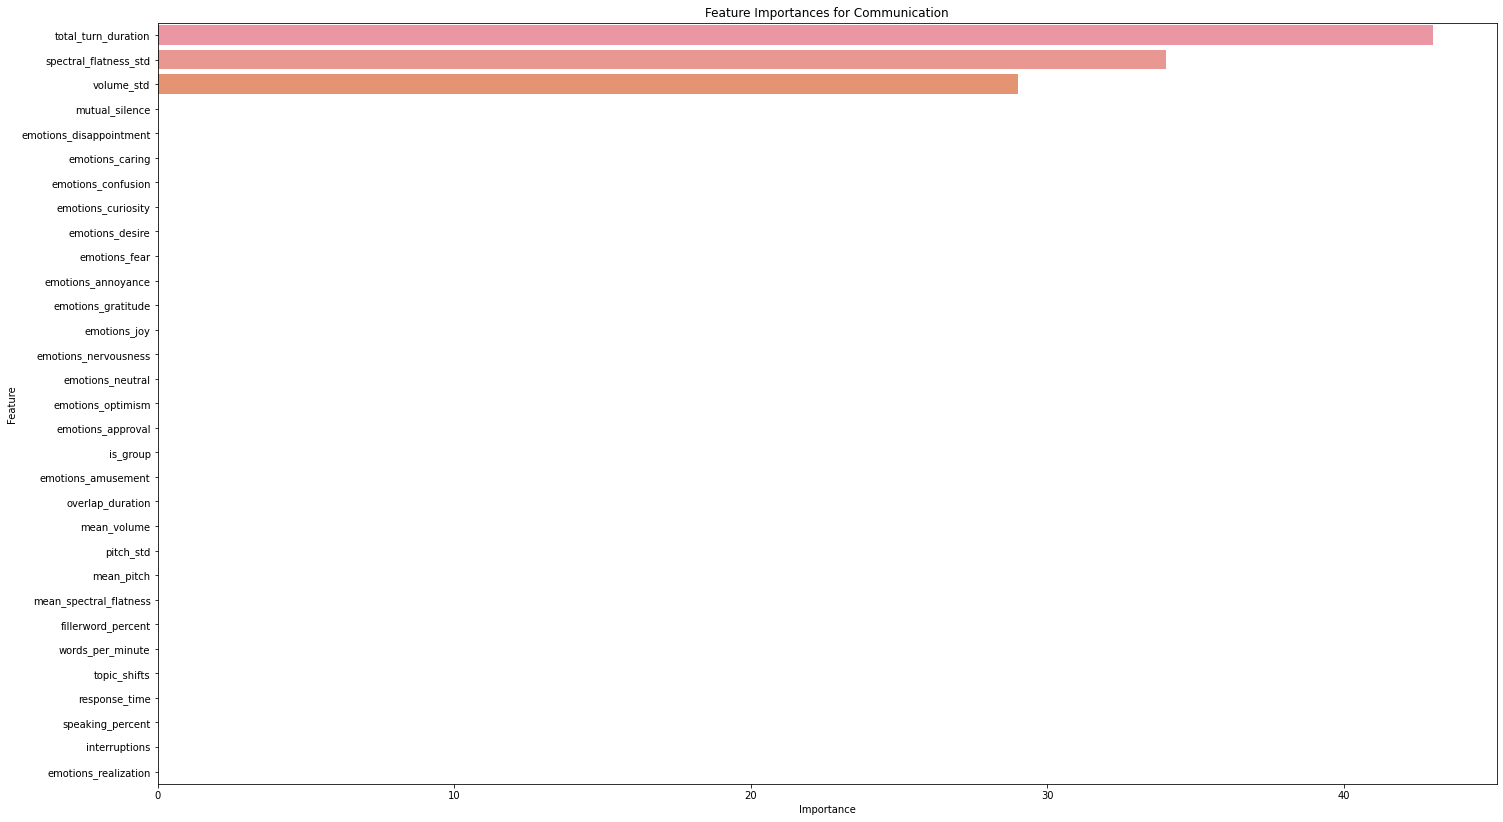

In [ ]:
#visualize feature importances

fig, ax = plt.subplots(figsize=(24, 14))
sns.barplot(y='Feature', x='Importance', data=feature_importances, orient='h')
plt.title('Feature Importances for Communication')
plt.show();